In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
HeaderTransaction = spark.read.option("inferSchema", "true").csv("./HeaderTransaction.csv", header=True)
MsBarn = spark.read.option("inferSchema", "true").csv("./MsBarn.csv", header=True)
MsBrand = spark.read.option("inferSchema", "true").csv("./MsBrand.csv", header=True)
MsFarmer = spark.read.option("inferSchema", "true").csv("./MsFarmer.csv", header=True)
MsFeed = spark.read.option("inferSchema", "true").csv("./MsFeed.csv", header=True)
TransactionDetail = spark.read.option("inferSchema", "true").csv("./TransactionDetail.csv", header=True)

In [4]:
HeaderTransaction.createOrReplaceTempView("HeaderTransaction")
MsBarn.createOrReplaceTempView("MsBarn")
MsBrand.createOrReplaceTempView("MsBrand")
MsFarmer.createOrReplaceTempView("MsFarmer")
MsFeed.createOrReplaceTempView("MsFeed")
TransactionDetail.createOrReplaceTempView("TransactionDetail")

+------------+-----+
|   BrandName|Total|
+------------+-----+
|      Ailane|  538|
|       Rooxo|  366|
|Twitterworks|  346|
|  Jabbercube|  343|
|     Nlounge|  332|
|       Jatri|  308|
|    Snaptags|  281|
|    Edgewire|  268|
|  Photospace|  268|
|     Voonder|  244|
+------------+-----+

      BrandName  Total
0        Ailane    538
1         Rooxo    366
2  Twitterworks    346
3    Jabbercube    343
4       Nlounge    332
5         Jatri    308
6      Snaptags    281
7      Edgewire    268
8    Photospace    268
9       Voonder    244


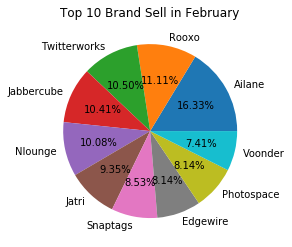

In [5]:
a = spark.sql("""
SELECT
    MsBrand.BrandName,
    SUM(TransactionDetail.Quantity) AS Total
FROM HeaderTransaction
JOIN TransactionDetail ON HeaderTransaction.TransactionID = TransactionDetail.TransactionID
JOIN MsFeed ON TransactionDetail.FeedID = MsFeed.FeedID
JOIN MsBrand ON MsFeed.BrandID = MsBrand.BrandID
WHERE MONTH(HeaderTransaction.TransactionDate) = 2
GROUP BY MsBrand.BrandName
ORDER BY Total DESC
LIMIT 10
""")

a.show()
a = a.toPandas()
print(a)

plt.title("Top 10 Brand Sell in February")
plt.pie(a["Total"], labels=a["BrandName"], autopct="%.2f%%")
plt.show()

+--------+-----+
|TxNumber|Month|
+--------+-----+
|       4|    1|
|       5|    2|
|       2|    3|
|       4|    4|
|       3|    5|
|       3|    6|
|       1|    7|
|       2|    8|
|       3|    9|
|       3|   10|
|       4|   11|
|       3|   12|
+--------+-----+

    TxNumber  Month
0          4      1
1          5      2
2          2      3
3          4      4
4          3      5
5          3      6
6          1      7
7          2      8
8          3      9
9          3     10
10         4     11
11         3     12


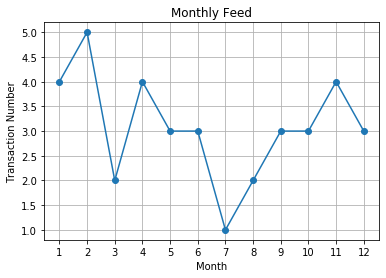

In [6]:
b = spark.sql("""
SELECT
    COUNT(HeaderTransaction.TransactionID) AS TxNumber,
    MONTH(HeaderTransaction.TransactionDate) AS Month
FROM HeaderTransaction
JOIN MsFarmer ON HeaderTransaction.FarmerID = MsFarmer.FarmerID
JOIN MsBarn ON MsFarmer.FarmerID = MsBarn.FarmerID
JOIN TransactionDetail ON HeaderTransaction.TransactionID = TransactionDetail.TransactionID
WHERE TransactionDetail.Quantity < 35 AND MsBarn.HasHayLoft = 0
GROUP BY Month
ORDER BY Month ASC
""")

b.show()
b = b.toPandas()
print(b)

plt.title("Monthly Feed")
plt.plot(b["Month"], b["TxNumber"], marker='o')

plt.xlabel("Month")
plt.ylabel("Transaction Number")

plt.xticks(range(1, len(b["Month"]) + 1), b["Month"])
plt.grid(True)
plt.show()

+--------+----+
|FeedSold|Freq|
+--------+----+
|    High|  11|
|     Low|  93|
|  Medium| 346|
+--------+----+

  FeedSold  Freq
0     High    11
1      Low    93
2   Medium   346


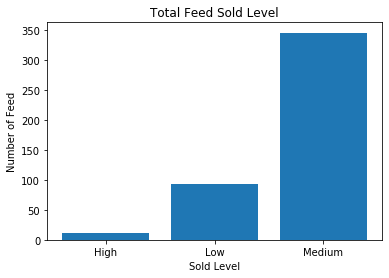

In [7]:
c = spark.sql("""
SELECT
    SubQuery.FeedSold,
    COUNT(SubQuery.FeedSold) AS Freq
FROM(
    SELECT
        TransactionDetail.FeedID,
        CASE
            WHEN SUM(TransactionDetail.Quantity) < 50 THEN 'Low'
            WHEN SUM(TransactionDetail.Quantity) > 200 THEN 'High'
            ELSE 'Medium'
        END AS FeedSold
    FROM HeaderTransaction
    JOIN TransactionDetail ON HeaderTransaction.TransactionID = TransactionDetail.TransactionID
    WHERE MONTH(HeaderTransaction.TransactionDate) < 8
    GROUP BY TransactionDetail.FeedID
) AS SubQuery
GROUP BY SubQuery.FeedSold
""")

c.show()
c = c.toPandas()
print(c)

plt.bar(c['FeedSold'], c['Freq'])
plt.xlabel('Sold Level')
plt.ylabel('Number of Feed')
plt.title('Total Feed Sold Level')
plt.show()